In [13]:
!pip install gym pandas numpy matplotlib stable-baselines3 optuna shimmy

In [14]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
import random, itertools
import optuna
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

# 2) Load & preprocess your data

In [15]:
df = pd.read_csv('/content/raw_data.csv', parse_dates=['date'], index_col='date')
df['hvac_energy'] = (df['Appliances'] - df['lights']).clip(lower=0)

# 3) Train/test split (70% train, 30% test)

In [16]:
split = int(len(df) * 0.7)
train_df = df.iloc[:split].reset_index(drop=True)
test_df  = df.iloc[split:].reset_index(drop=True)

# 4) Custom HVAC Gym Environment

In [17]:
class HVACEnv(gym.Env):
    def __init__(self, data, desired_temp=22.0, lam=0.1):
        super().__init__()
        self.df = data
        self.desired_temp = desired_temp
        self.lam = lam
        self.action_space = spaces.Discrete(4)  # Off/Low/Med/High

        # Observation: avg(T1–T9), T_out, occupancy (lights>0), hour_of_day
        low  = np.array([self.df[['T1','T2','T3','T4','T5','T6','T7','T8','T9']].min().min(),
                         self.df['T_out'].min(), 0, 0], dtype=np.float32)
        high = np.array([self.df[['T1','T2','T3','T4','T5','T6','T7','T8','T9']].max().max(),
                         self.df['T_out'].max(), 1, 23], dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # Percentile thresholds for HVAC energy (0%, 25%, 50%, 75%)
        self.thresholds = np.percentile(self.df['hvac_energy'], [0,25,50,75])
        self.reset()

    def reset(self):
        self.idx = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.iloc[self.idx]
        avg_in = row[['T1','T2','T3','T4','T5','T6','T7','T8','T9']].mean()
        out    = row['T_out']
        occ    = 1.0 if row['lights'] > 0 else 0.0
        hr     = (self.idx % 24)
        return np.array([avg_in, out, occ, hr], dtype=np.float32)

    def step(self, action):
        energy   = float(self.thresholds[action])
        comfort  = abs(self._get_obs()[0] - self.desired_temp)
        reward   = -(energy + self.lam * comfort)
        self.idx += 1
        done     = self.idx >= len(self.df)
        obs      = self._get_obs() if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, done, {}

# 6) Training & evaluation helper

In [19]:
def train_and_eval(env, params, train_steps=50_000, eval_eps=5):
    model = DQN(
        'MlpPolicy', env,
        gamma=params['gamma'],
        learning_rate=params['learning_rate'],
        buffer_size=int(params['buffer_size']),
        batch_size=int(params['batch_size']),
        train_freq=int(params['train_freq']),
        verbose=0
    )
    model.learn(total_timesteps=train_steps)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=eval_eps)
    return mean_reward

# 7) Hyperparameter searches

In [20]:
def random_search(env, n=8):
    best = {'score':-np.inf,'params':None}
    for _ in range(n):
        p = {
            'gamma': random.choice([0.9,0.95,0.99]),
            'learning_rate': 10**random.uniform(-5,-3),
            'buffer_size': random.choice([5000,10000,20000]),
            'batch_size': random.choice([32,64,128]),
            'train_freq': random.choice([4,8,16])
        }
        s = train_and_eval(env,p)
        if s>best['score']: best={'score':s,'params':p}
    return best

def grid_search(env):
    grid = {
        'gamma':[0.9,0.95],
        'learning_rate':[1e-5,1e-4],
        'buffer_size':[5000,10000],
        'batch_size':[32,64],
        'train_freq':[4,8]
    }
    best={'score':-np.inf,'params':None}
    for combo in itertools.product(*grid.values()):
        p=dict(zip(grid.keys(),combo))
        s=train_and_eval(env,p)
        if s>best['score']: best={'score':s,'params':p}
    return best

def bayesian_search(env, n_trials=12):
    def obj(trial):
        p = {
            'gamma': trial.suggest_categorical('gamma',[0.9,0.95,0.99]),
            'learning_rate': trial.suggest_loguniform('learning_rate',1e-5,1e-3),
            'buffer_size': trial.suggest_categorical('buffer_size',[5000,10000,20000]),
            'batch_size': trial.suggest_categorical('batch_size',[32,64,128]),
            'train_freq': trial.suggest_categorical('train_freq',[4,8,16])
        }
        return train_and_eval(env,p)
    study=optuna.create_study(direction='maximize')
    study.optimize(obj, n_trials=n_trials)
    return {'score':study.best_value,'params':study.best_params}

# 8) Run searches

In [21]:
env_train=HVACEnv(train_df)
r_best=random_search(env_train)
g_best=grid_search(env_train)
b_best=bayesian_search(env_train)

print("Random:", r_best)
print("Grid:  ", g_best)
print("Bayes: ", b_best)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment f

Random: {'score': np.float64(-4896.012100683547), 'params': {'gamma': 0.99, 'learning_rate': 0.0008385504677258256, 'buffer_size': 20000, 'batch_size': 32, 'train_freq': 4}}
Grid:   {'score': np.float64(-4896.012100683547), 'params': {'gamma': 0.9, 'learning_rate': 1e-05, 'buffer_size': 5000, 'batch_size': 32, 'train_freq': 4}}
Bayes:  {'score': -4896.012100683547, 'params': {'gamma': 0.95, 'learning_rate': 6.613799996357628e-05, 'buffer_size': 20000, 'batch_size': 32, 'train_freq': 4}}


# 9) Train final DQN with best Bayesian params

In [22]:
params=b_best['params']
model = DQN('MlpPolicy', env_train,
            gamma=params['gamma'],
            learning_rate=params['learning_rate'],
            buffer_size=int(params['buffer_size']),
            batch_size=int(params['batch_size']),
            train_freq=int(params['train_freq']),
            verbose=1)
model.learn(total_timesteps=50_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


# 10) Evaluate on test set & compute savings

In [23]:
env_test = HVACEnv(test_df)
baseline_wh = test_df['hvac_energy'].sum()

obs = env_test.reset(); rl_wh = 0.0; done=False
while not done:
    action,_ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env_test.step(action)
    rl_wh += env_test.thresholds[action]

energy_savings = baseline_wh - rl_wh
cost_savings   = energy_savings * (0.12/1000)  # $0.12 per kWh

# 11) Plot

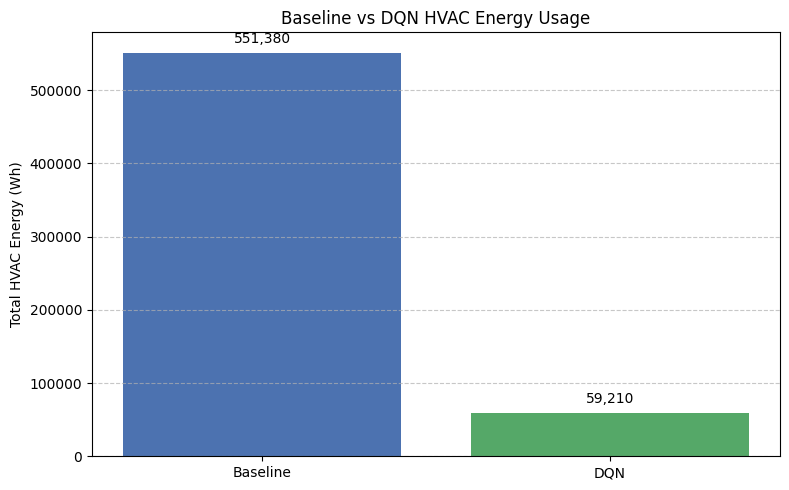

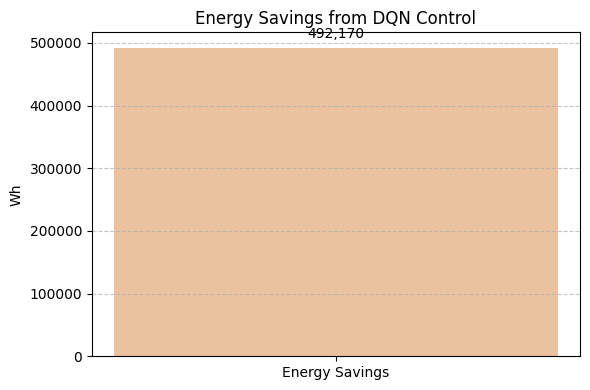

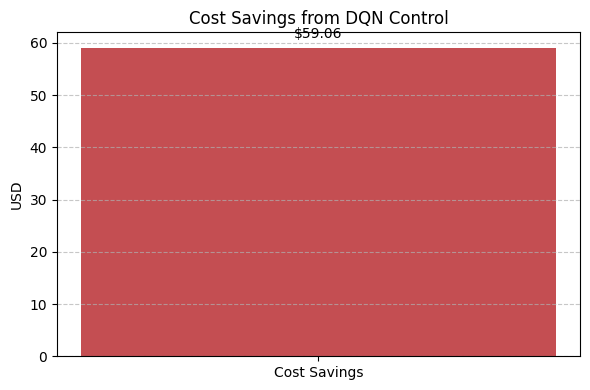

In [27]:
import matplotlib.pyplot as plt

# 1) Energy Usage Comparison
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['Baseline', 'DQN'], [baseline_wh, rl_wh], color=['#4c72b0','#55a868'])
ax.set_ylabel('Total HVAC Energy (Wh)')
ax.set_title('Baseline vs DQN HVAC Energy Usage')
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5), textcoords='offset points',
                ha='center', va='bottom')
plt.tight_layout()

# 2) Energy Savings
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Energy Savings'], [energy_savings], color='#ebc29f')
ax.set_ylabel('Wh')
ax.set_title('Energy Savings from DQN Control')
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5), textcoords='offset points',
                ha='center', va='bottom')
plt.tight_layout()

# 3) Cost Savings
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Cost Savings'], [cost_savings], color='#c44e52')
ax.set_ylabel('USD')
ax.set_title('Cost Savings from DQN Control')
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'${height:,.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5), textcoords='offset points',
                ha='center', va='bottom')
plt.tight_layout()
plt.show()
